In [2]:
import numpy as np

def dbscan1(X, eps, min_pts):
    """
    DBSCAN clustering algorithm implementation using NumPy

    Parameters:
    X (ndarray): Input data of shape (n_samples, n_features)
    eps (float): Maximum distance between two samples for them to be considered as in the same neighborhood
    min_pts (int): Minimum number of samples in a neighborhood to consider a point as a core point

    Returns:
    labels (ndarray): Array of cluster labels for each data point. -1 indicates noise.
    """

    n_samples = X.shape[0]
    visited = np.zeros(n_samples, dtype=bool)
    labels = np.zeros(n_samples, dtype=int)

    # Compute pairwise distances between data points
    dists = np.sqrt(np.sum((X[:, np.newaxis] - X[np.newaxis, :]) ** 2, axis=2))

    # Find core points
    core_pts = np.sum(dists <= eps, axis=1) >= min_pts

    # Label core points and find neighboring points
    curr_label = 0
    for i in range(n_samples):
        if not visited[i] and core_pts[i]:
            visited[i] = True
            labels[i] = curr_label
            neighbors = np.where(dists[i] <= eps)[0]
            for j in neighbors:
                if not visited[j]:
                    visited[j] = True
                    labels[j] = curr_label
                    if core_pts[j]:
                        neighbors = np.concatenate([neighbors, np.where(dists[j] <= eps)[0]])
            curr_label += 1

    # Label non-core points
    for i in range(n_samples):
        if not visited[i]:
            labels[i] = -1  # mark as noise

    return labels


In [3]:
import numpy as np
from numba import njit, prange
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed

@njit(parallel=True)
def pairwise_distances(X):
    n_samples = X.shape[0]
    dists = np.zeros((n_samples, n_samples))
    for i in prange(n_samples):
        for j in prange(i, n_samples):
            d = np.sqrt(np.sum((X[i] - X[j]) ** 2))
            dists[i, j] = d
            dists[j, i] = d
    return dists

@njit
def find_neighbors(dists, eps):
    neighbors = []
    for i in range(dists.shape[0]):
        row = dists[i]
        indices = np.where(row <= eps)[0]
        neighbors.append(indices)
    return neighbors

@njit
def expand_cluster(X, neighbors, visited, labels, i, curr_label, eps, min_pts):
    visited[i] = True
    labels[i] = curr_label
    seed = set(neighbors[i])
    while seed:
        j = seed.pop()
        if not visited[j]:
            visited[j] = True
            labels[j] = curr_label
            if len(neighbors[j]) >= min_pts:
                seed.update(neighbors[j])

@njit
def dbscan2(X, eps, min_pts):
    n_samples = X.shape[0]
    visited = np.zeros(n_samples, dtype=bool)
    labels = np.zeros(n_samples, dtype=int)

    # Compute pairwise distances between data points in parallel
    dists = pairwise_distances(X)

    # Find neighbors in parallel
    neighbors = find_neighbors(dists, eps)

    # Label core points and find neighboring points in parallel
    curr_label = 0
    for i in range(n_samples):
        if not visited[i] and len(neighbors[i]) >= min_pts:
            expand_cluster(X, neighbors, visited, labels, i, curr_label, eps, min_pts)
            curr_label += 1

    # Label non-core points
    for i in range(n_samples):
        if not visited[i]:
            labels[i] = -1  # mark as noise

    return labels


In [4]:
from algorithms import Kmeans
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import time

In [5]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

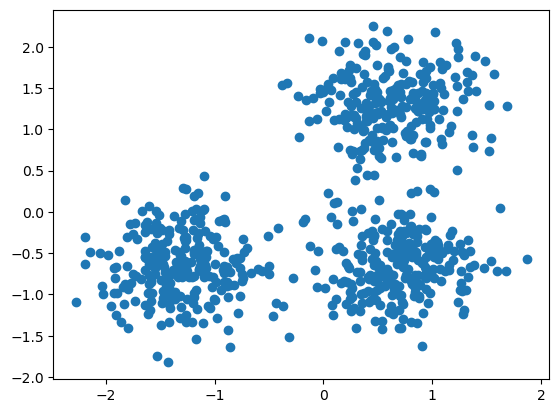

In [6]:
plt.scatter(X[::,0], X[::,1])

In [7]:
#db1 = KMeans(n_clusters=3, init='k-means++')
tic = time.time()
y = dbscan1(X, 0.5, 5)
toc = time.time()
print("Runtime {:.3f}'s".format(toc - tic))

Runtime 0.113's


In [8]:
#db1 = KMeans(n_clusters=3, init='k-means++')
tic = time.time()
y = dbscan2(X, 0.5, 5)
toc = time.time()
print("Runtime {:.3f}'s".format(toc - tic))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(int64, dtype=Function(<class 'bool'>))
 
There are 2 candidate implementations:
[1m     - Of which 2 did not match due to:
     Overload in function 'ol_np_zeros': File: numba/np/arrayobj.py: Line 4164.
       With argument(s): '(int64, dtype=Function(<class 'bool'>))':[0m
[1m      Rejected as the implementation raised a specific error:
        TypingError: Failed in nopython mode pipeline (step: nopython frontend)
      [1m[1m[1mNo implementation of function Function(<built-in function empty>) found for signature:
       
       >>> empty(int64, dtype=Function(<class 'bool'>))
       
      There are 2 candidate implementations:
      [1m      - Of which 2 did not match due to:
            Overload in function 'ol_np_empty': File: numba/np/arrayobj.py: Line 4086.
              With argument(s): '(int64, dtype=Function(<class 'bool'>))':[0m
      [1m       Rejected as the implementation raised a specific error:
               TypingError: [1mCannot parse input types to function np.empty(int64, Function(<class 'bool'>))[0m[0m
        raised from /Users/emmanuelayanful/anaconda3/lib/python3.10/site-packages/numba/np/arrayobj.py:4105
      [0m
      [0m[1mDuring: resolving callee type: Function(<built-in function empty>)[0m
      [0m[1mDuring: typing of call at /Users/emmanuelayanful/anaconda3/lib/python3.10/site-packages/numba/np/arrayobj.py (4169)
      [0m
      [1m
      File "../../../../anaconda3/lib/python3.10/site-packages/numba/np/arrayobj.py", line 4169:[0m
      [1m    def impl(shape, dtype=float):
      [1m        arr = np.empty(shape, dtype=dtype)
      [0m        [1m^[0m[0m
[0m
  raised from /Users/emmanuelayanful/anaconda3/lib/python3.10/site-packages/numba/core/typeinfer.py:1086
[0m
[0m[1mDuring: resolving callee type: Function(<built-in function zeros>)[0m
[0m[1mDuring: typing of call at /var/folders/rg/yqn64f6d3_g24c4_4n053lph0000gn/T/ipykernel_12093/2799020480.py (42)
[0m
[1m
File "../../../../../../var/folders/rg/yqn64f6d3_g24c4_4n053lph0000gn/T/ipykernel_12093/2799020480.py", line 42:[0m
[1m<source missing, REPL/exec in use?>[0m


In [9]:
prange?

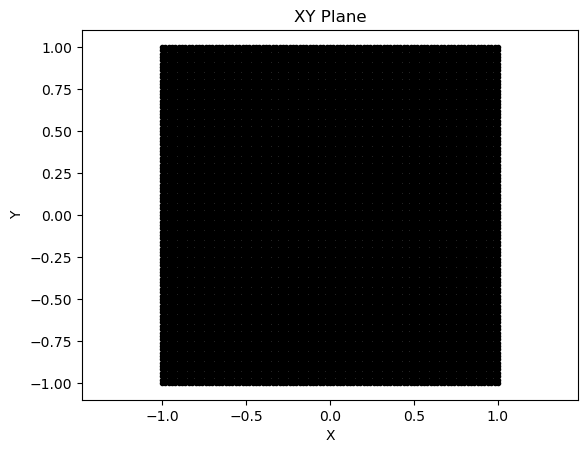

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of points on the XY plane
x = np.linspace(-1, 1, 101)
y = np.linspace(-1, 1, 101)
X, Y = np.meshgrid(x, y)

# Plot the XY plane
plt.figure()
plt.plot(X, Y, 'k.')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('XY Plane')
plt.show()
